In [45]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict

In [46]:
def printattr(name, object):
    print(name)
h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_170_gev_with_spanet_KLFitter.h5', "r")
h5py_file.visititems(printattr)

jet_features
jet_features/barcode
jet_features/btag
jet_features/eta
jet_features/event
jet_features/mass
jet_features/num_of_jets
jet_features/phi
jet_features/pt
klfitter
klfitter/left_target
klfitter/left_target/b
klfitter/right_target
klfitter/right_target/b
klfitter/right_target/q1
klfitter/right_target/q2
klfitter/score
klfitter/score/event_probability
klfitter/score/loglikelihood
lepton_features
lepton_features/charge
lepton_features/eta
lepton_features/mass
lepton_features/phi
lepton_features/pid
lepton_features/pt
met_features
met_features/MET
met_features/eta
met_features/phi
met_features/sumet
neutrino_eta
neutrino_eta/spanet
neutrino_eta/target
parton_features
parton_features/eta
parton_features/masks
parton_features/mass
parton_features/parton_barcode
parton_features/pdgid
parton_features/phi
parton_features/pt
spanet
spanet/left_target
spanet/left_target/b
spanet/left_target/detection
spanet/left_target/mask
spanet/right_target
spanet/right_target/b
spanet/right_target/de

In [47]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    # 55 < reco_m_W < 110
    # 0.3 < reco_R_bq < 3.0
    """

    cut1 = np.logical_and(dic['reconstructed_top_mass'] > 100, dic['reconstructed_top_mass'] < 300)
    # cut2 = np.logical_and(dic['reconstructed_W_mass'] < 110, dic['reconstructed_W_mass'] > 55)
    # cut3 = np.logical_and(dic['reconstructed_R_bq'] < 3.0, dic['reconstructed_R_bq'] > 0.3)
    cuts = cut1

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    a_or_b = np.logical_or(a, b)
    right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(right, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)

    
    for key in dic: dic[key] = dic[key][cuts]
    state = state[cuts]
    if target == 'klfitter':
        return dic['reconstructed_top_mass'], state, h5py_file['klfitter/score/loglikelihood'][:][cuts]
    else:
        return dic['reconstructed_top_mass'], state

In [48]:
# The reco_top_mss from ttbar_testing_mass_variation
mass = [170, 171, 172, 173, 174, 175, 176]
state_labels = ['Unmatched', 'Incorrect', 'Correct']

reco_spanet_dic = {}
reco_klf_dic = {}
reco_target_dic = {}

state_spanet_dic = {} # 0 for unmatched, 1 for incorrect, 2 for correct
state_klf_dic = {}
state_target_dic = {}

loglikeli_klf_dic = {}

for m in mass:
    h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
    reco_spanet_dic[m], state_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    reco_klf_dic[m], state_klf_dic[m], loglikeli_klf_dic[m]  = get_reco_top_mass(h5py_file, 'klfitter')
    reco_target_dic[m], state_target_dic[m] = get_reco_top_mass(h5py_file, 'target')

KeyboardInterrupt: 

In [ ]:
# Fixed the bins, colors, and tot_event for all plots.
bins = np.arange(100, 301, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
tot_event = 100000

In [ ]:
h5py_file = h5py.File('ttbar_testing_sm/ttbar_testing_sm.h5'.format(m), "r")
reco_spanet, state_spanet = get_reco_top_mass(h5py_file, 'spanet')

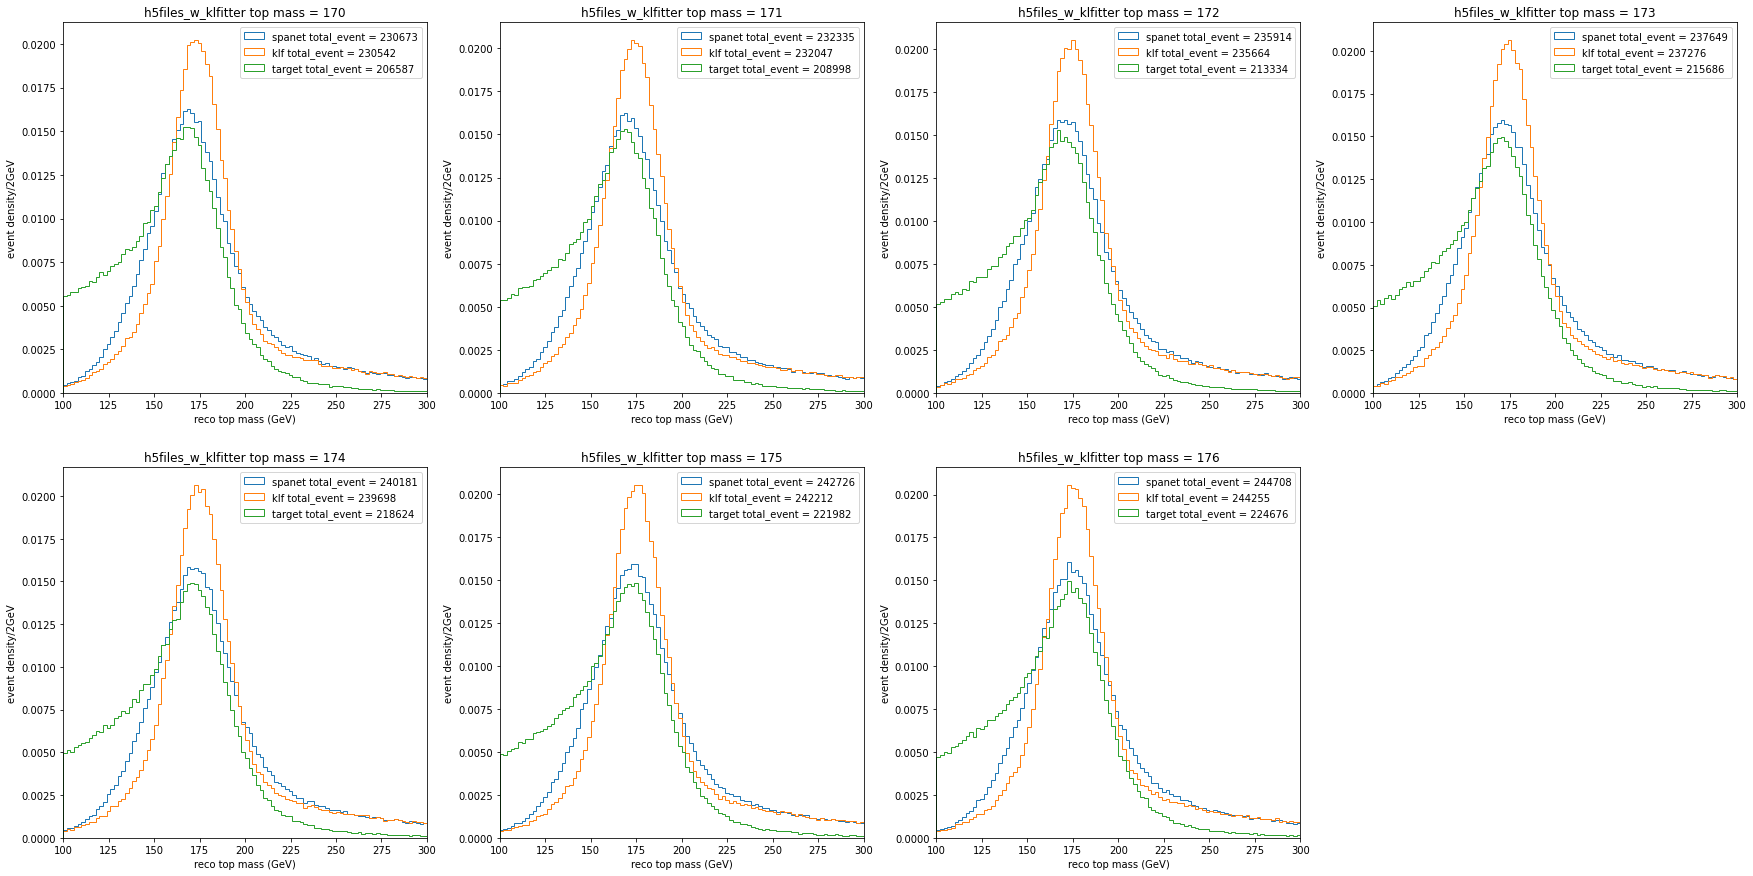

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(reco_spanet_dic[m], bins=bins, density=True, histtype='step', label='spanet total_event = ' + str(len(reco_spanet_dic[m])))
    plt.hist(reco_klf_dic[m], bins=bins, density=True, histtype='step', label='klf total_event = ' + str(len(reco_klf_dic[m])))
    plt.hist(reco_target_dic[m], bins=bins, density=True, histtype='step', label='target total_event = ' + str(len(reco_target_dic[m])))
    plt.title('h5files_w_klfitter top mass = {}'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event density/2GeV')
    plt.legend(loc='upper right')
plt.show()

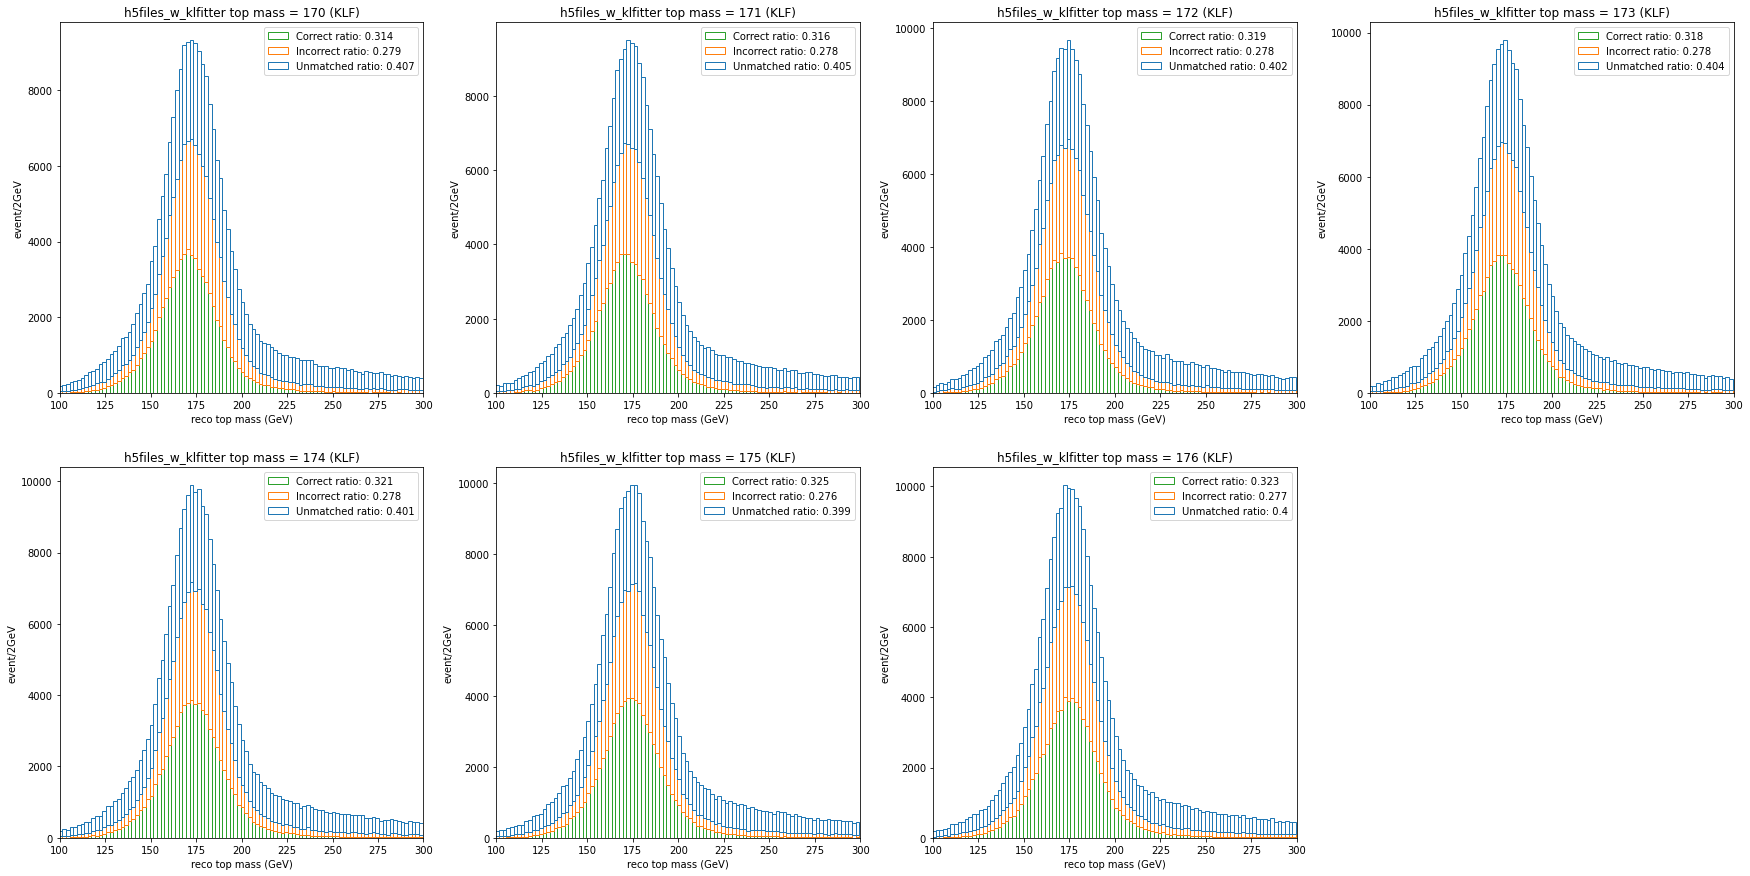

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_klf_dic[m]==i)/len(state_klf_dic[m])
        hist, bin_edges = np.histogram(reco_klf_dic[m][state_klf_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (KLF)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

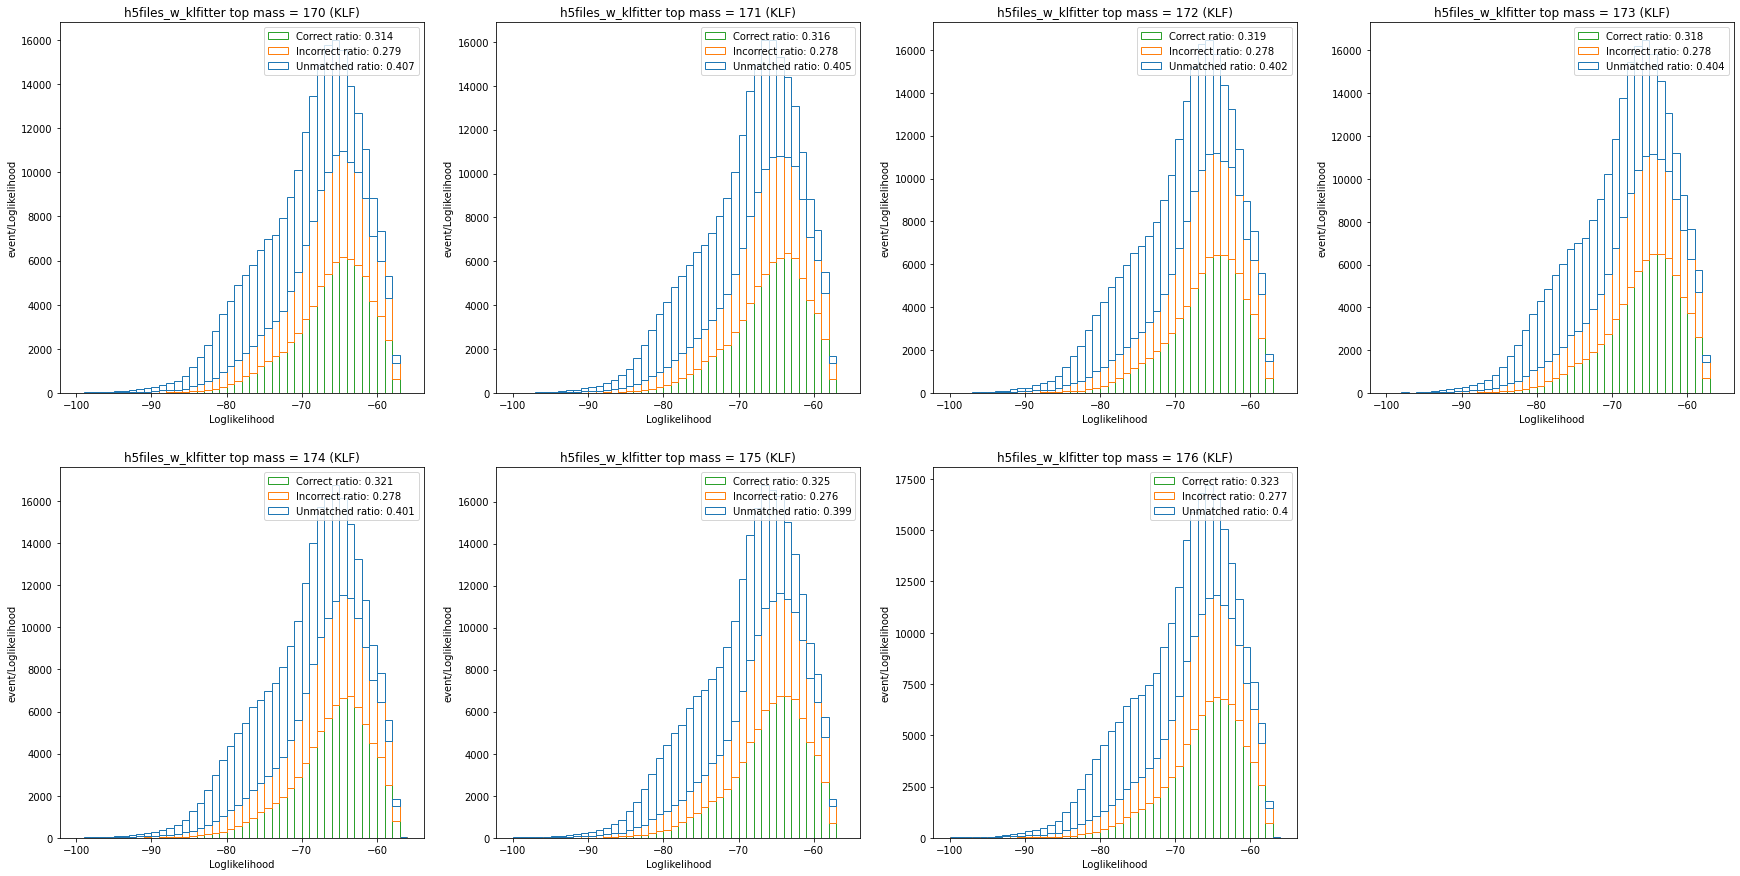

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*44
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_klf_dic[m]==i)/len(state_klf_dic[m])
        hist, bin_edges = np.histogram(loglikeli_klf_dic[m][state_klf_dic[m] == i], bins=np.arange(-100, -55, 1))
        plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=1, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (KLF)'.format(m))
    plt.xlabel('Loglikelihood')
    plt.ylabel('event/Loglikelihood')
    plt.legend(loc='upper right')
plt.show()

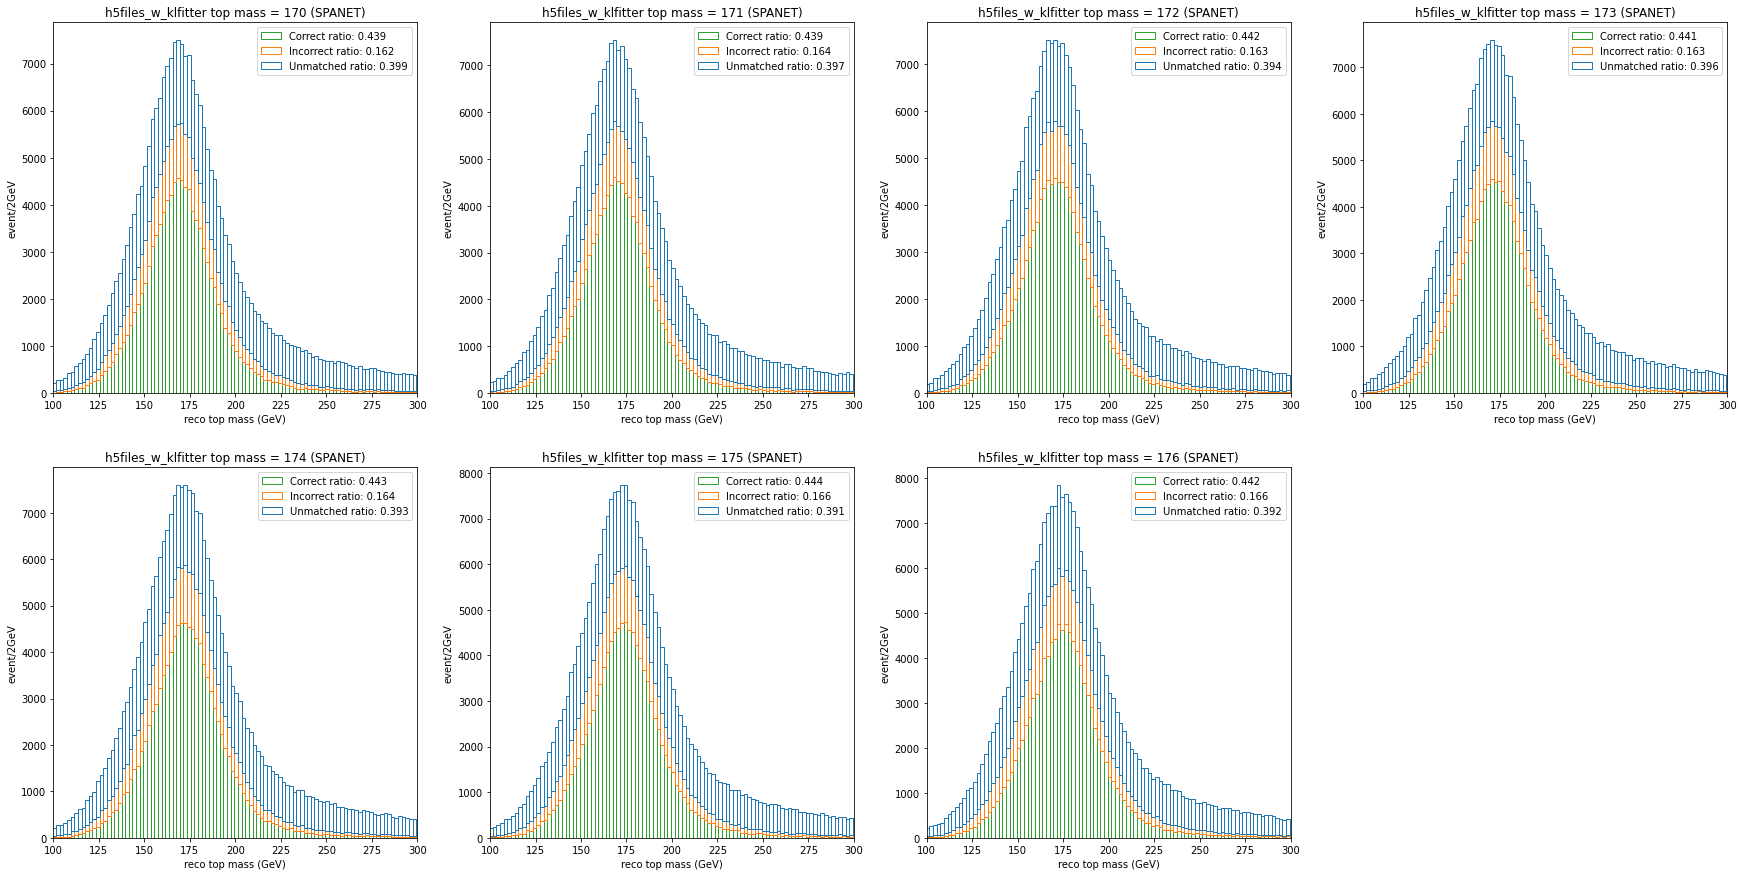

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_spanet_dic[m]==i)/len(state_spanet_dic[m])
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (SPANET)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

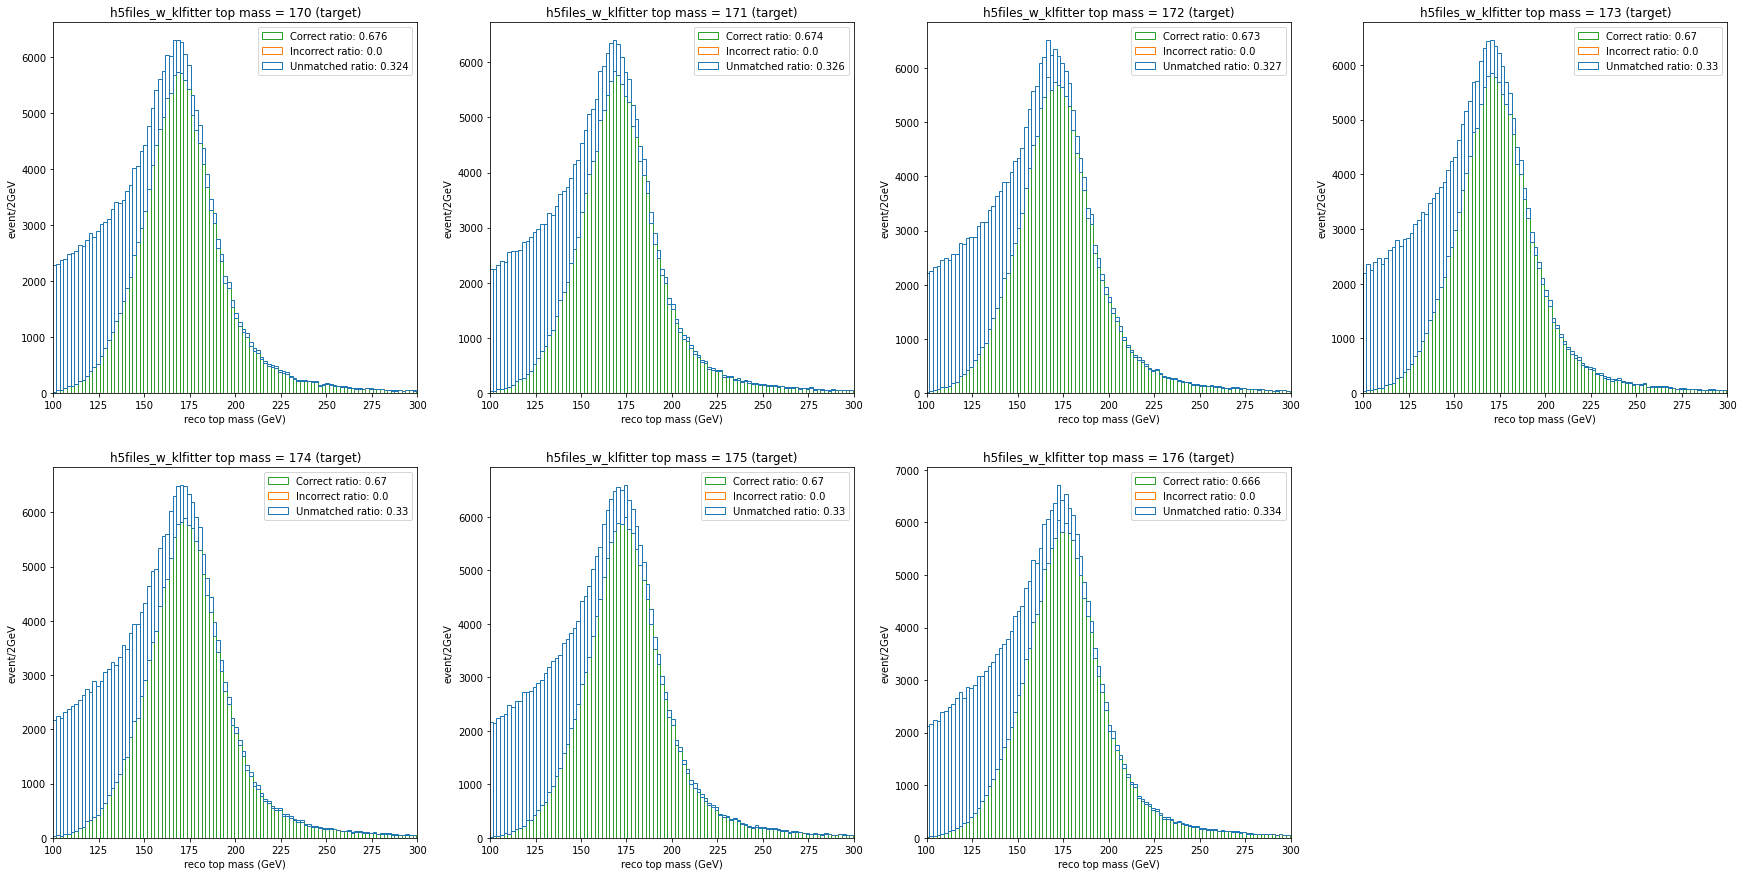

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_target_dic[m]==i)/len(state_target_dic[m])
        hist, bin_edges = np.histogram(reco_target_dic[m][state_target_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (target)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

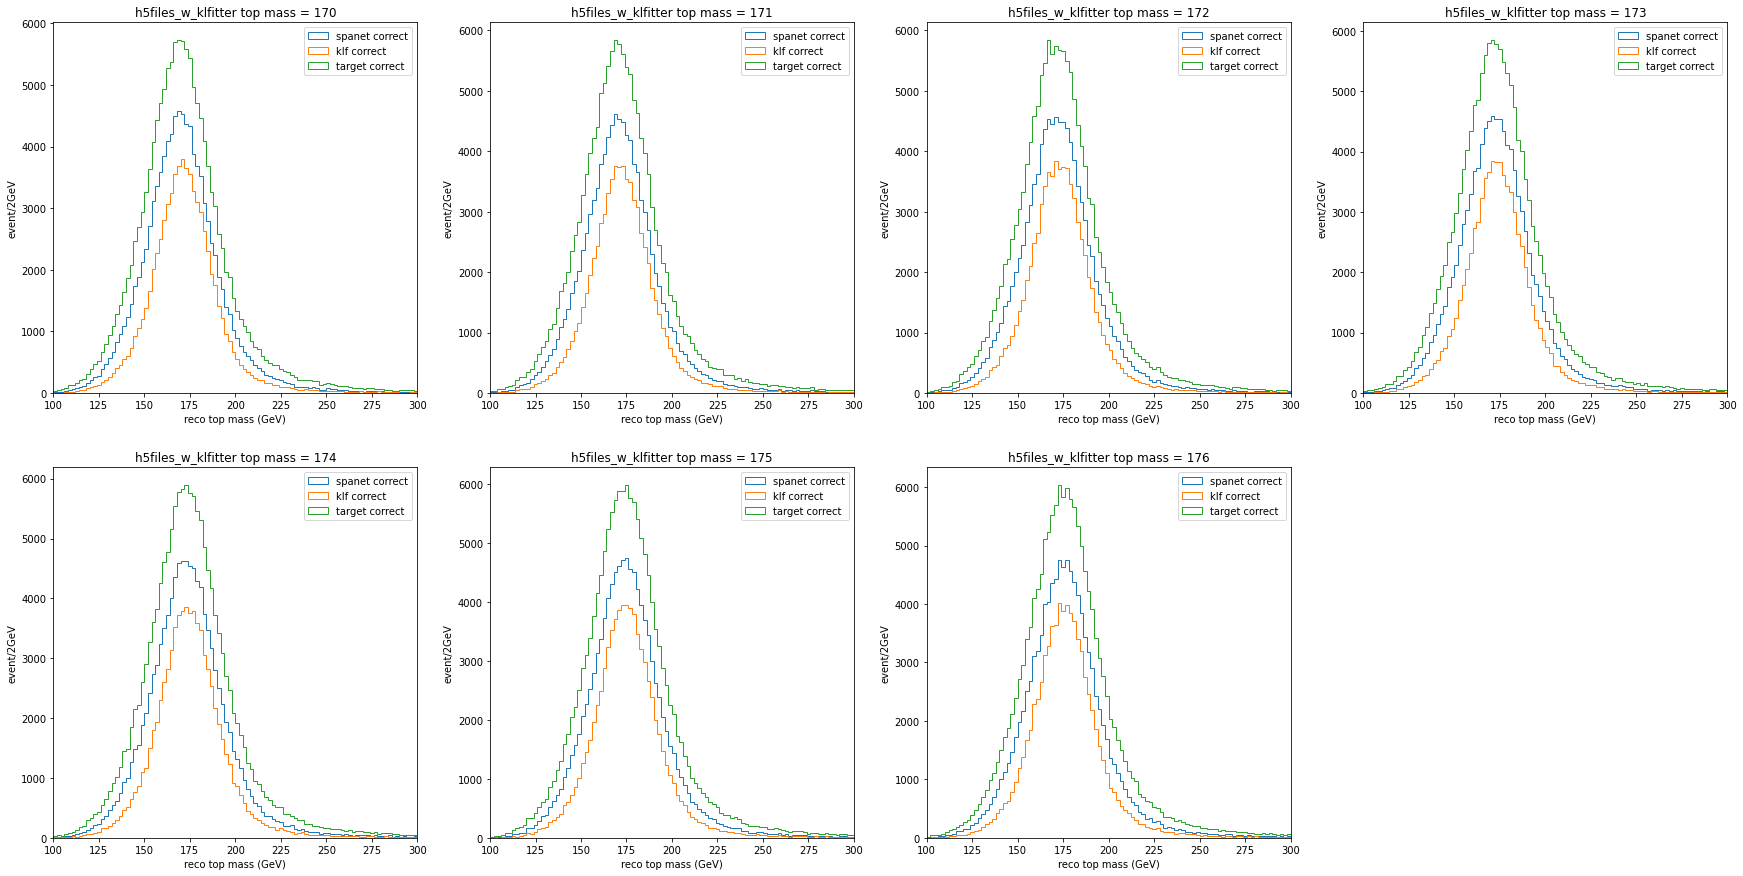

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(reco_spanet_dic[m][state_spanet_dic[m] == 2], bins=bins, histtype='step', label='spanet correct')
    plt.hist(reco_klf_dic[m][state_klf_dic[m] == 2], bins=bins, histtype='step', label='klf correct')
    plt.hist(reco_target_dic[m][state_target_dic[m] == 2], bins=bins, histtype='step', label='target correct')
    plt.title('h5files_w_klfitter top mass = {}'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

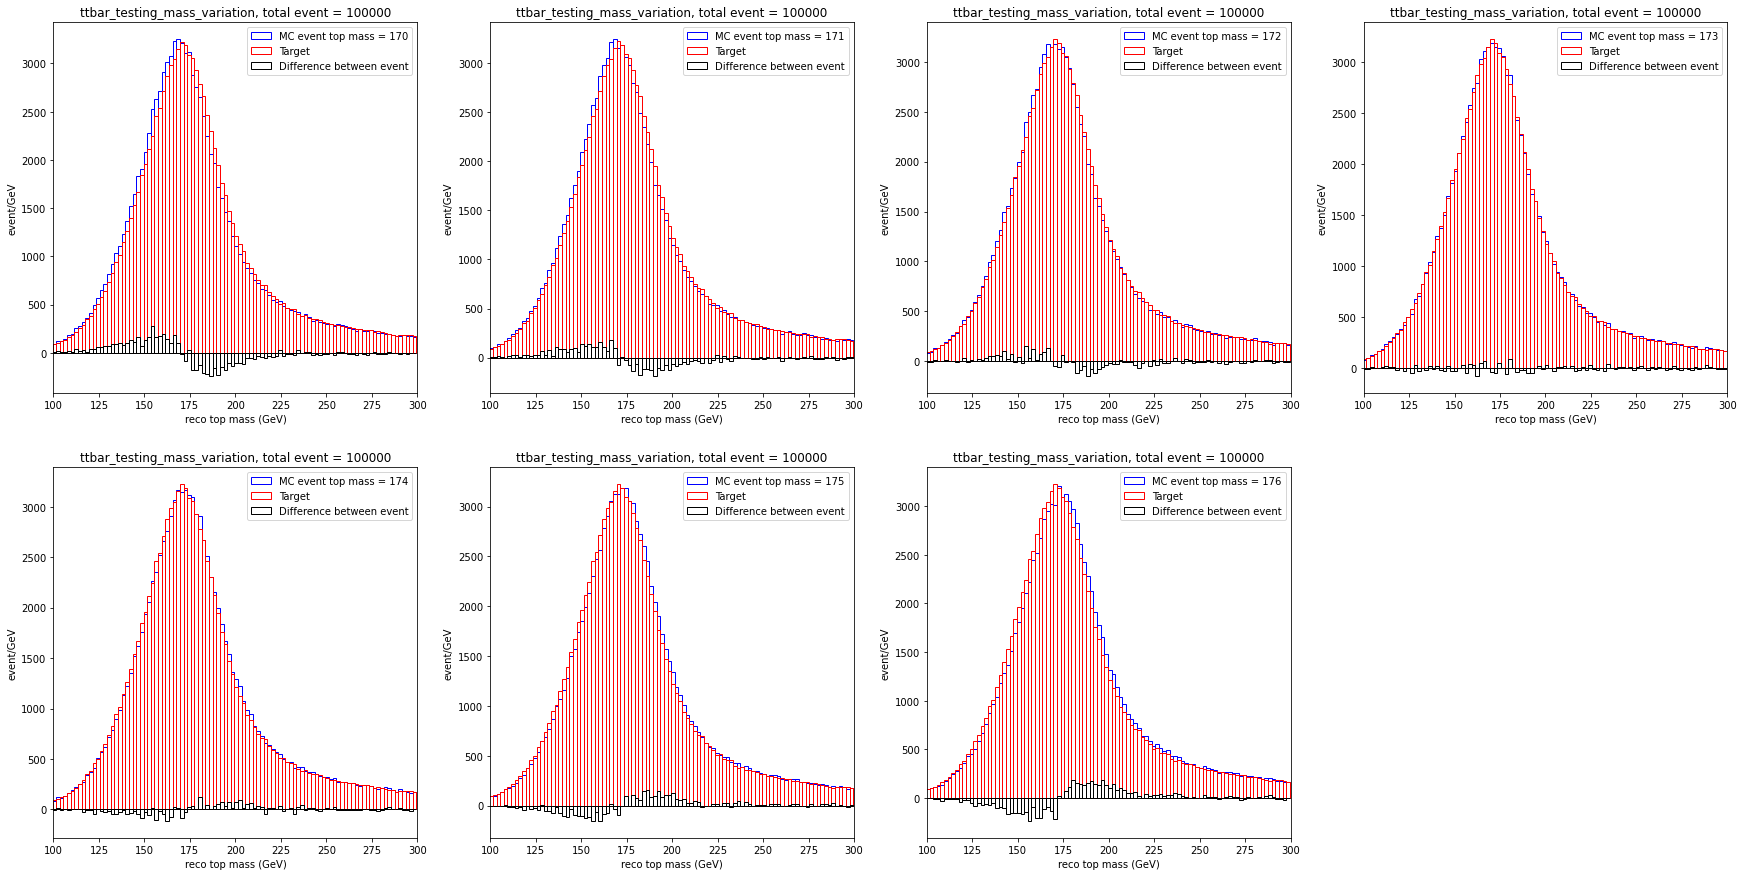

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    hist1, bin_edges = np.histogram(reco_spanet_dic[m], bins=bins)
    hist1 = hist1*tot_event/sum(hist1)
    hist2, bin_edges = np.histogram(reco_spanet, bins=bins)
    hist2 = hist2*tot_event/sum(hist2)
    plt.bar(bin_edges[:-1]+0.5, hist1, edgecolor='blue', width=2, color='None', label = 'MC event top mass = {}'.format(m))
    plt.bar(bin_edges[:-1]+0.5, hist2, edgecolor='red', width=2, color='None', label = 'Target')
    plt.bar(bin_edges[:-1]+0.5, hist1-hist2, edgecolor='black', width=2, color='None', label = 'Difference between event')
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
def langau(x, lan_size, lan_loc, lan_scale, gau_size, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return lan_size*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + gau_size*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized landau distribution.
def lan_norm(x, lan_loc, lan_scale):
    lan_y = (x-lan_loc)/lan_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale

# One gaussian distribution.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Two gaussian distributions.
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Linear
def linear(x, a, b):
    return a*x+b

In [ ]:
def chi2_pdf(mt1, n2): #mt1 is the observation, n2 is the height of the bins from pdf.
    n1, _ = np.histogram(mt1, bins=bins)
    n2 *= 2*len(mt1)
    chi2_value = 2*sum([n2[i] - n1[i] + n1[i]*np.log(n1[i]/n2[i]) if n1[i]!=0 else n2[i] for i in range(len(n1))])
    return chi2_value

Unmatched gau [176.6074587   46.12534314]
Unmatched lan [162.69496613  26.79377759]
Unmatched langau [1.62419371e+02 2.76842374e+01 1.74238327e+02 1.48538090e+01
 3.35938522e-02]


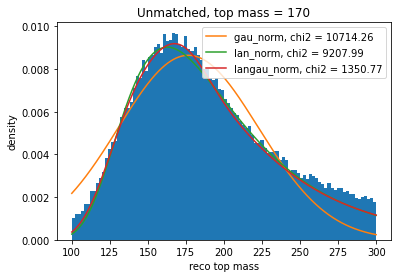

Unmatched gau [176.66559258  45.98036643]
Unmatched lan [162.88490077  26.67761563]
Unmatched langau [1.62741275e+02 2.78113951e+01 1.72631443e+02 1.53399018e+01
 4.06555227e-02]


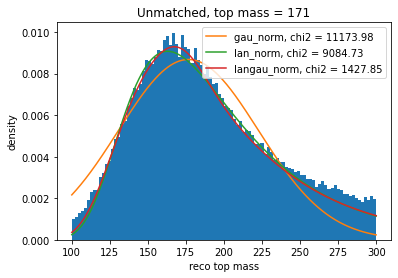

Unmatched gau [177.13158109  46.10628502]
Unmatched lan [163.17987586  26.74460615]
Unmatched langau [1.62966874e+02 2.75423569e+01 1.74440613e+02 1.50736693e+01
 3.01040594e-02]


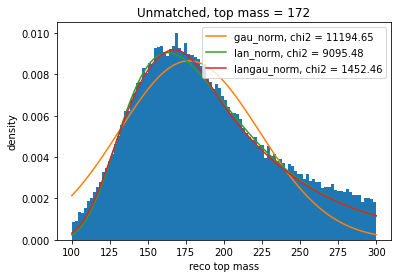

Unmatched gau [177.77198075  46.17084983]
Unmatched lan [163.87064347  26.85975249]
Unmatched langau [1.63765228e+02 2.80160142e+01 1.73245627e+02 1.56565238e+01
 4.09659793e-02]


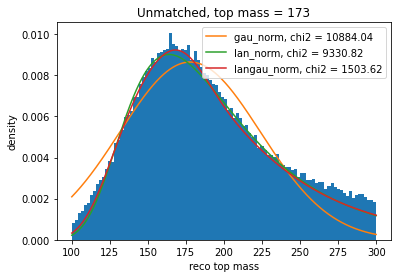

Unmatched gau [178.00534446  46.16391808]
Unmatched lan [164.00634882  26.78849503]
Unmatched langau [1.63963692e+02 2.76913604e+01 1.73274487e+02 1.65531481e+01
 3.33958770e-02]


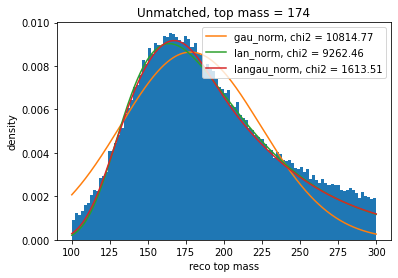

Unmatched gau [178.29841549  46.29059672]
Unmatched lan [164.32443306  26.895079  ]
Unmatched langau [1.64191112e+02 2.80770973e+01 1.74265607e+02 1.62669613e+01
 4.33156872e-02]


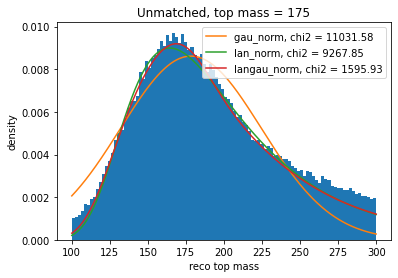

Unmatched gau [179.11692479  46.5838979 ]
Unmatched lan [164.93888235  27.05312746]
Unmatched langau [1.64924286e+02 2.80840072e+01 1.73199476e+02 1.47036483e+01
 3.43303815e-02]


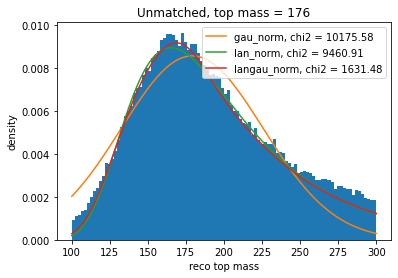

Incorrect gau [168.00437303  25.75793102]
Incorrect lan [160.09024878  15.89497355]
Incorrect langau [181.28443193  16.6924986  161.71030684  22.04402586   0.7016696 ]


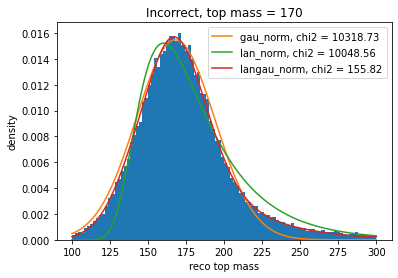

Incorrect gau [168.54699399  26.02013728]
Incorrect lan [160.48283848  16.05543892]
Incorrect langau [182.21110216  17.20277435 162.6430558   22.49633326   0.71698819]


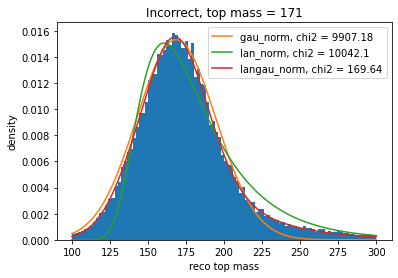

Incorrect gau [168.50155861  25.91856044]
Incorrect lan [160.48004912  16.00945661]
Incorrect langau [183.22879607  16.27657207 161.59943348  21.56706899   0.69274618]


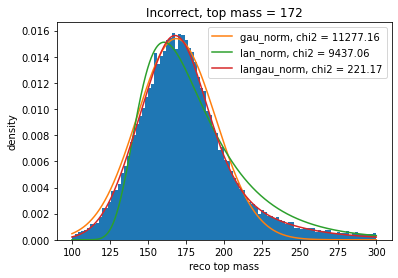

Incorrect gau [169.20670708  25.94246905]
Incorrect lan [161.19220949  16.00974237]
Incorrect langau [182.39680395  15.48509551 161.3393738   21.39175621   0.66502117]


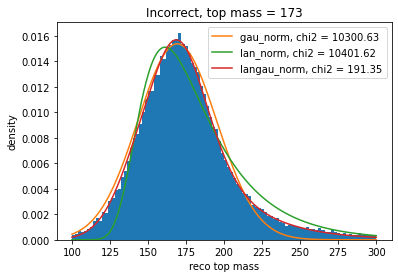

Incorrect gau [169.43377736  26.16556715]
Incorrect lan [161.36909886  16.15040161]
Incorrect langau [181.83376993  15.78996829 161.84326329  22.06787626   0.67152977]


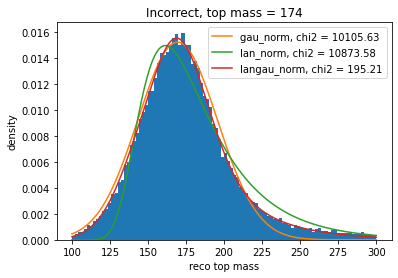

Incorrect gau [169.74123193  26.17630157]
Incorrect lan [161.72247378  16.11099178]
Incorrect langau [183.06539215  17.20973516 163.23371601  22.23630457   0.69236174]


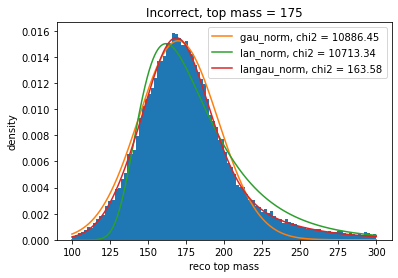

Incorrect gau [169.97016995  26.34413103]
Incorrect lan [161.85048323  16.24318076]
Incorrect langau [183.35059106  17.20690429 163.43427698  22.45623929   0.69547873]


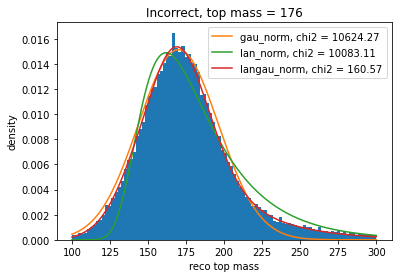

Correct gau [168.72279741  18.38873992]
Correct lan [163.20166806  11.28701401]
Correct langau [153.58283856  18.12697353 169.89912752  14.94801345   0.6873542 ]


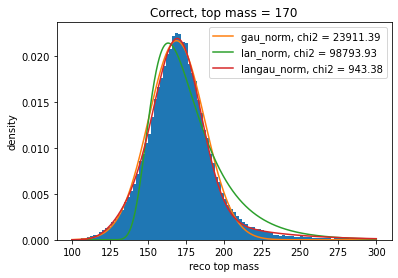

Correct gau [169.50656976  18.46226532]
Correct lan [163.93086587  11.36640089]
Correct langau [153.9782414   17.68288096 170.85522092  14.88758736   0.67588129]


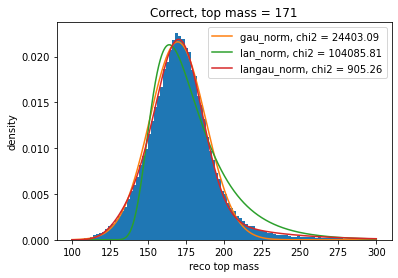

Correct gau [170.42935557  18.51623456]
Correct lan [164.90364518  11.3599232 ]
Correct langau [154.71218596  17.93919655 171.73466295  14.93130828   0.67937913]


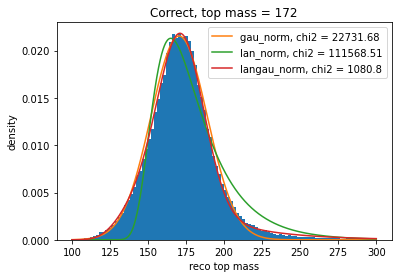

Correct gau [171.24928809  18.68161381]
Correct lan [165.59410326  11.49284256]
Correct langau [176.18968101   9.61195981 166.00455969  17.71436622   0.69316426]


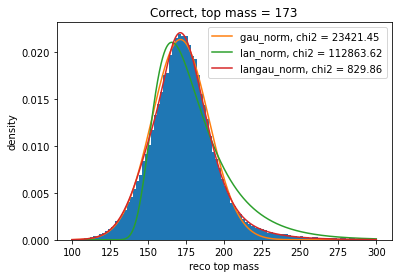

Correct gau [172.15305893  18.78024382]
Correct lan [166.4468367   11.54890275]
Correct langau [177.09879754   9.68867524 166.80058756  17.75368025   0.68866299]


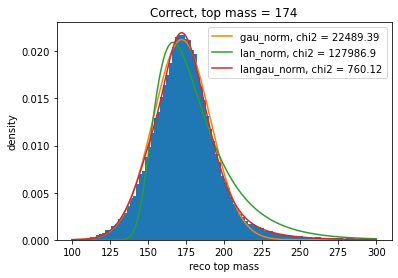

Correct gau [172.98073815  18.73124399]
Correct lan [167.34682532  11.51622248]
Correct langau [157.04182106  17.97054536 174.33982273  15.13091731   0.67938914]


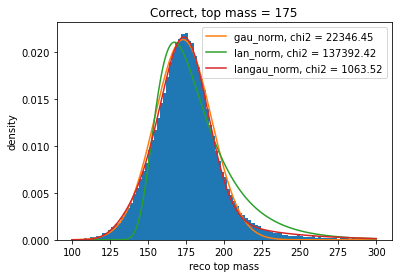

Correct gau [173.84796384  18.89750532]
Correct lan [168.12492388  11.66133277]
Correct langau [157.57838007  17.60627084 175.45087084  14.99476326   0.65757145]


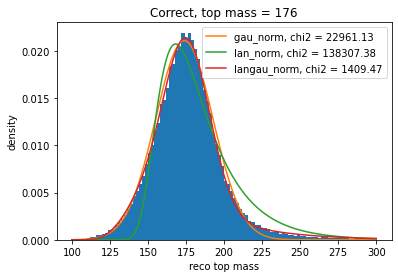

In [ ]:
for state_i in [0, 1, 2]:
    for m in mass:
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        x = np.linspace(100, 300, 10000)

        # Fit to a Gaussian
        popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20), method="lm")
        y_gau_norm = gau_norm(x, popt[0], popt[1])
        print(state_labels[state_i] + ' gau', popt)
        chi_gau_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==state_i], gau_norm(bins[:-1]+1, popt[0], popt[1]))
        
        # Fit to a landau
        popt, pcov = optimize.curve_fit(lan_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20), method="lm")
        y_lan_norm = lan_norm(x, popt[0], popt[1])
        print(state_labels[state_i] + ' lan', popt)
        chi_lan_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==1], lan_norm(bins[:-1]+1, popt[0], popt[1]))
        
        # Fit to a Langau
        popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20, 150, 20, 0.5), method="lm")
        print(state_labels[state_i] + ' langau', popt)
        y_langau_norm = langau_norm(x, popt[0], popt[1], popt[2], popt[3], popt[4])
        chi_langau_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==state_i], langau_norm(bins[:-1]+1, popt[0], popt[1], popt[2], popt[3], popt[4]))

        plt.hist(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        plt.plot(x, y_gau_norm, label='gau_norm, chi2 = {}'.format(round(chi_gau_norm, 2)))
        plt.plot(x, y_lan_norm, label='lan_norm, chi2 = {}'.format(round(chi_lan_norm, 2)))
        plt.plot(x, y_langau_norm, label='langau_norm, chi2 = {}'.format(round(chi_langau_norm, 2)))
        plt.title(state_labels[state_i] + ', top mass = {}'.format(m))
        plt.xlabel('reco top mass')
        plt.ylabel('density')
        plt.legend(loc='upper right')
        plt.show()

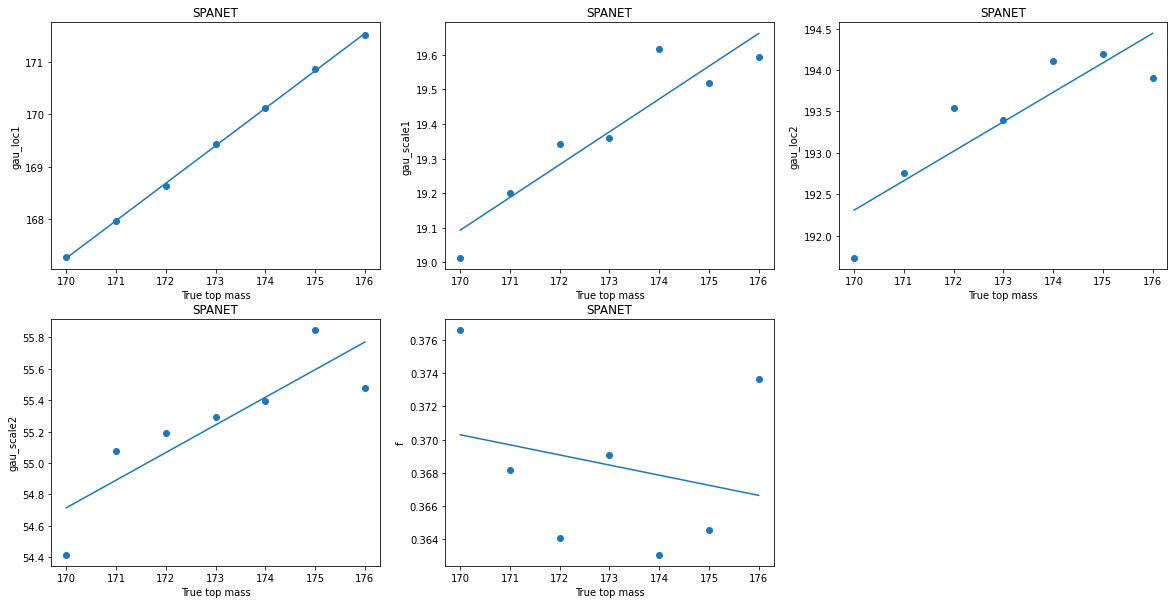

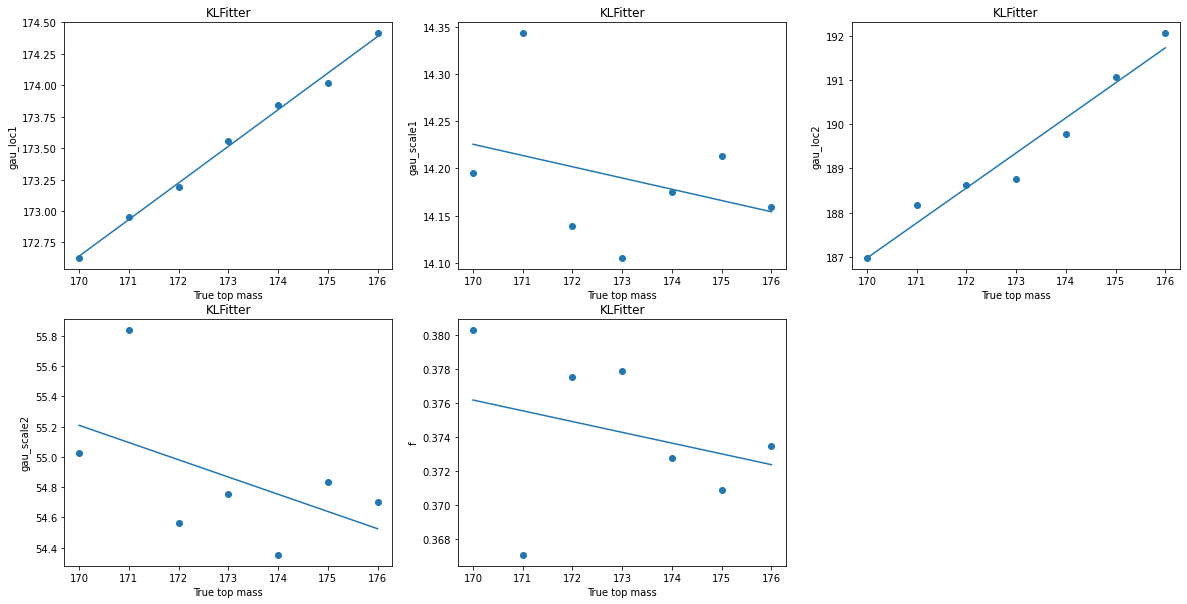

In [ ]:
# Fit all to two_gau_norm
popt_spanet_arr = []
popt_klf_arr = []
for i, m in enumerate(mass):
    hist, bin_edges = np.histogram(reco_spanet_dic[m], bins=bins, density=True)
    popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 100, 100, 100, 0.9), method="lm")
    popt_spanet_arr.append(popt)

    hist, bin_edges = np.histogram(reco_klf_dic[m], bins=bins, density=True)
    popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 100, 100, 100, 0.9), method="lm")
    popt_klf_arr.append(popt)

fit_labels = ['gau_loc1', 'gau_scale1', 'gau_loc2', 'gau_scale2', 'f']
x = np.linspace(170, 176, 100)

popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
popt_klf_arr = np.transpose(np.array(popt_klf_arr))

fita_spanet_arr, fitb_spanet_arr = [], []
fita_klf_arr, fitb_klf_arr = [], []

plt.figure(figsize=(20, 10))
for i, arr in enumerate(popt_spanet_arr):
    popt, pcov = optimize.curve_fit(linear, mass, arr, method="lm")
    plt.subplot(2, 3, i+1)
    plt.scatter(mass, arr)
    y = linear(x, popt[0], popt[1])
    plt.plot(x, y)
    plt.xlabel('True top mass')
    plt.ylabel(fit_labels[i])
    plt.title('SPANET')
    fita_spanet_arr.append(popt[0])
    fitb_spanet_arr.append(popt[1])
plt.show()

plt.figure(figsize=(20, 10))
for i, arr in enumerate(popt_klf_arr):
    popt, pcov = optimize.curve_fit(linear, mass, arr, method="lm")
    plt.subplot(2, 3, i+1)
    plt.scatter(mass, arr)
    y = linear(x, popt[0], popt[1])
    plt.plot(x, y)
    plt.xlabel('True top mass')
    plt.ylabel(fit_labels[i])
    plt.title('KLFitter')
    fita_klf_arr.append(popt[0])
    fitb_klf_arr.append(popt[1])
plt.show()

In [ ]:
top_mass_arr = np.linspace(170, 176, 1000)
chi2_target = np.random.choice(reco_spanet, size = 9000, replace=False)

chi2_spanet_arr = [chi2_pdf(chi2_target,
            two_gau_norm(bins[:-1]+1,
            fita_spanet_arr[0]*m+fitb_spanet_arr[0],
            fita_spanet_arr[1]*m+fitb_spanet_arr[1],
            fita_spanet_arr[2]*m+fitb_spanet_arr[2],
            fita_spanet_arr[3]*m+fitb_spanet_arr[3],
            fita_spanet_arr[4]*m+fitb_spanet_arr[4])) for m in top_mass_arr]

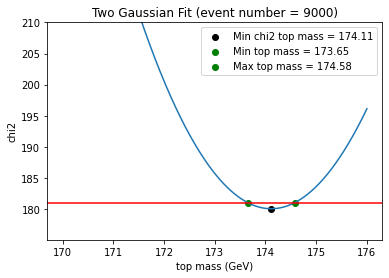

In [60]:
plt.plot(top_mass_arr, chi2_spanet_arr)
min_loc = [top_mass_arr[np.argmin(chi2_spanet_arr)], min(chi2_spanet_arr)]
passed_chi2_spanet_arr = [chi2 for chi2 in chi2_spanet_arr if chi2 < min(chi2_spanet_arr)+1]
plt.scatter(min_loc[0], min_loc[1], c='k', label = 'Min chi2 top mass = {}'.format(round(min_loc[0], 2)))
plt.scatter(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])], passed_chi2_spanet_arr[0], c='g', label='Min top mass = {}'.format(round(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])], 2)))
plt.scatter(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])], passed_chi2_spanet_arr[0], c='g', label='Max top mass = {}'.format(round(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])], 2)))
plt.axhline(min(chi2_spanet_arr)+1, c='r')
plt.ylim(min(chi2_spanet_arr)-5, min(chi2_spanet_arr)+30)
plt.title('Two Gaussian Fit (event number = {})'.format(len(chi2_target)))
plt.xlabel('top mass (GeV)')
plt.ylabel('chi2')
plt.legend()
plt.show()